In [1]:
# !pip3 install numpy taichi numba matplotlib

In [2]:
import numpy as np
import taichi as ti
from numba import jit
import matplotlib.pyplot as plt
%matplotlib inline

[Taichi] version 0.9.1, llvm 10.0.0, commit e2e0e669, linux, python 3.8.10
[I 03/24/22 02:40:41.063 7790] [shell.py:_shell_pop_print@33] Graphical python shell detected, using wrapped sys.stdout


## Множество Мандельброта
Рассмотрим в качестве примера кода для ускорения отрисовку [множества Мандельброта](https://ru.wikipedia.org/wiki/%D0%9C%D0%BD%D0%BE%D0%B6%D0%B5%D1%81%D1%82%D0%B2%D0%BE_%D0%9C%D0%B0%D0%BD%D0%B4%D0%B5%D0%BB%D1%8C%D0%B1%D1%80%D0%BE%D1%82%D0%B0) -- одного из наиболее известных фракталов. 

Если отрисовать Мандельброта, то должно получиться что-то похожее на данную картинку
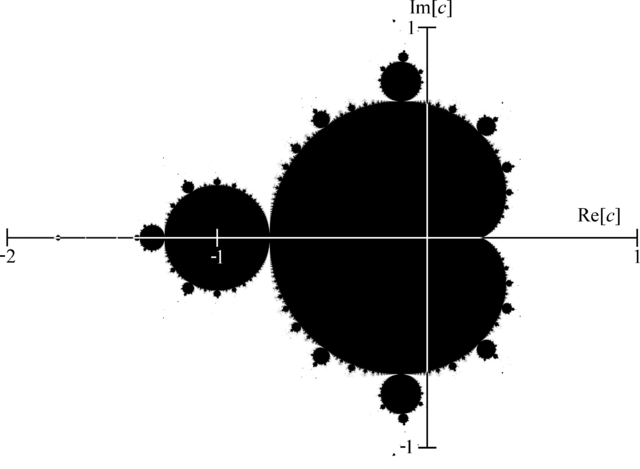

Ниже представлен код для вычисления множества Мандельброта  в цветном варианте. 
Если вкратце, то алгоритм вычисления множества Мандельброта таков:

* для каждой точки на плоскости с координатами $(x, y)$ мы формируем комлексное число $c = x + iy$. Стоит отметить, что для того, чтобы мы увидили что-то интересное, то у следует задать пределы для $ (-2 < x < 1), (-1.5 < y < 1.5)$
* задаем число $Z_0 = 0$
* запускаем вычисление последовательности $ Z_n = Z_{n-1} ^ 2 + C$
  В случае, если последовательность ограничена, то точка принадлежит ко множеству Мандельброта, иначе нет. 

  Так как мы не можем вычислять бесконечную последовательность, то мы задаем максимаьное количество итераций $N$.
  Также не имеет смысла продолжать вычисления, если $abs(Z_n) > 2$

* Если на предыдущем шаге закрашивать точку в цвет, соответствующий тому, на каком шаге мы закончили вычисление последовательности $Z_n$, то у нас получится цветной вариант множества. Где само множество по-прежнему будет черным, а на его границах будет градиент.


In [3]:
def naive_mandelbrot(
    w, h, min_x, max_x, min_y, max_y, max_iterations
):
    # Create empty image with shape = (w, h)
    image= np.zeros((h, w), dtype=np.float32)
    # Compute steps around X and Y axis
    dx = (max_x - min_x) / w
    dy = (max_y - min_y) / h
    
    # Iterate over X axis
    for x in range(w):
        real = min_x + x * dx
        # Iterate over Y axis
        for y in range(h):
            # Compute point C and Z_0
            im = min_y + y * dy
            c = real + 1j * im
            z = 0
            # Compute the color of the point
            for k in range(max_iterations):
                z = z ** 2 + c
                if abs(z) > 2:
                    image[y, x] = k / max_iterations    
                    break
    return image

Проверим, что все работает правильно. У нас должно получиться нечто, похожее на изображение выше.

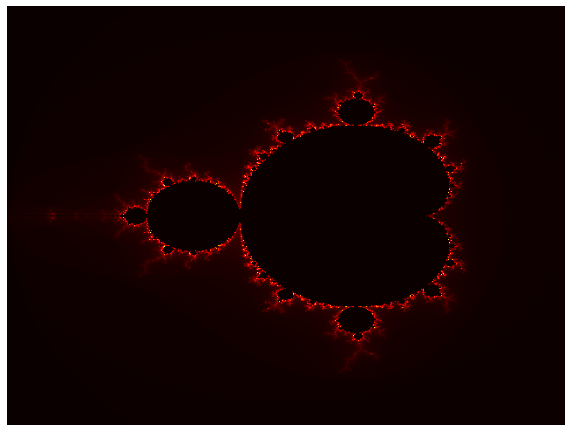

In [4]:
image = naive_mandelbrot(640, 480, -2, 1, -1.5, 1.5, 255)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(image, cmap='hot')

Давайте теперь поиграемся с параметром N, отвечающим за количество итераций:

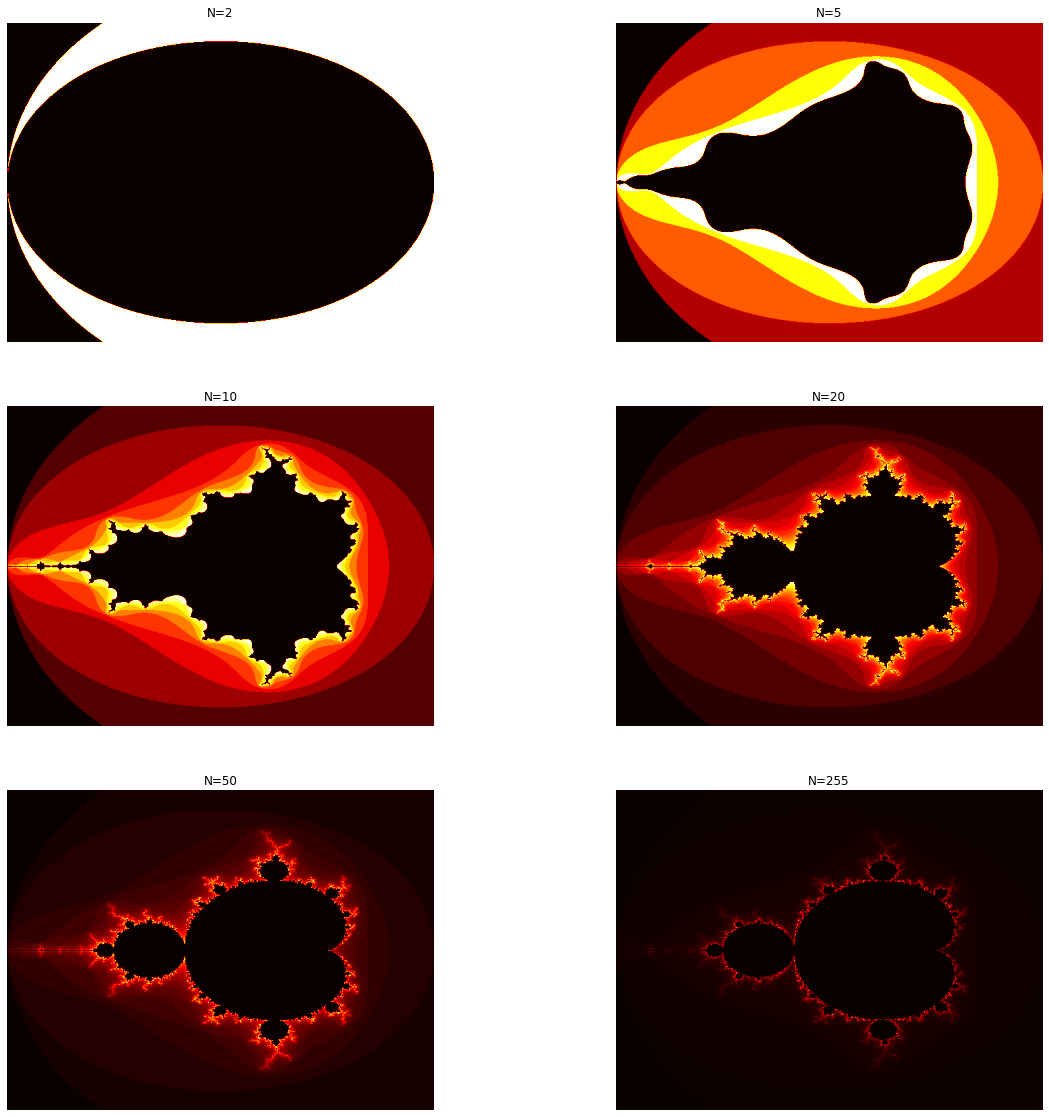

In [5]:
n_sequence = [2, 5, 10, 20, 50, 255]
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

for i, ax in enumerate(fig.get_axes()):
    n = n_sequence[i]
    image = naive_mandelbrot(640, 480, -2, 1, -1.5, 1.5, n)
    ax.set_title(f'N={n}')
    ax.axis('off')
    ax.imshow(image, cmap='hot')

Очевидно, что чем болльше у нас параметр N, тем более детальное множество Мандельброта. Но и тем больше нам необходимо провести вычислений.

Давайте теперь замерим скорость работы:

In [6]:
%timeit naive_mandelbrot(640, 480, -2, 1, -1.5, 1.5, 2)
%timeit naive_mandelbrot(640, 480, -2, 1, -1.5, 1.5, 5)
%timeit naive_mandelbrot(640, 480, -2, 1, -1.5, 1.5, 10)
%timeit naive_mandelbrot(640, 480, -2, 1, -1.5, 1.5, 20)
%timeit naive_mandelbrot(640, 480, -2, 1, -1.5, 1.5, 50)
%timeit naive_mandelbrot(640, 480, -2, 1, -1.5, 1.5, 255)

222 ms ± 3.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
312 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
382 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
489 ms ± 7.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
737 ms ± 2.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.36 s ± 6.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Numpy

Как мы видим, отрисовка довольно медленная. Давайте попробуем переписать код с использованием Numpy. 

In [8]:
def numpy_mandelbrot(
    w, h, min_x, max_x, min_y, max_y, max_iterations
):
    # Create empty image with shape = (w, h)
    image= np.zeros((h, w), dtype=np.float64)
    
    # Compute points C and Z_0
    x_linspace = np.linspace(min_x, max_x, w)
    y_linspace = np.linspace(min_y, max_y, h)
    c = x_linspace[np.newaxis, :] +\
        1j * y_linspace[:, np.newaxis]
    z = np.zeros_like(c)
    # Compute the colors for all points
    for k in range(max_iterations):
        mask = image == 0
        z[mask] = z[mask] ** 2 + c[mask]
        mask = (mask & (np.abs(z) > 2))
        image[mask] = float(k) / max_iterations
    return image

Проверим, что рисуется то, что нужно

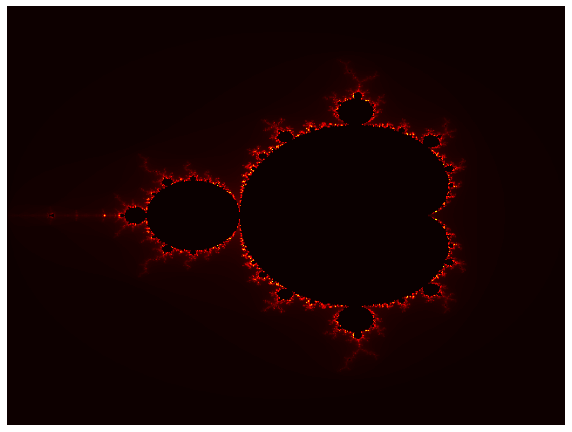

In [9]:
image = numpy_mandelbrot(640, 480, -2, 1, -1.5, 1.5, 255)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(image, cmap='hot')

In [10]:
%timeit numpy_mandelbrot(640, 480, -1, 2, -1.5, 1.5, 255)

925 ms ± 26.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Cython

Уже намного быстрее, но все равно недостаточно. Давайте попробуем запустить то же самое, но с использованием Cython. В начале мы вообще никак не будем менять код исходной функции `naive_mandelbrot`.

In [11]:
%load_ext Cython

In [12]:
%%cython

import numpy as np

def cython_mandelbrot(
    w, h, min_x, max_x, min_y, max_y, max_iterations
):
    # Create empty image with shape = (w, h)
    image= np.zeros((h, w), dtype=np.float32)
    # Compute steps around X and Y axis
    dx = (max_x - min_x) / w
    dy = (max_y - min_y) / h
    
    # Iterate over X axis
    for x in range(w):
        real = min_x + x * dx
        # Iterate over Y axis
        for y in range(h):
            # Compute point C and Z_0
            im = min_y + y * dy
            c = real + 1j * im
            z = 0
            # Compute the color of the point
            for k in range(max_iterations):
                z = z ** 2 + c
                if abs(z) > 2:
                    image[y, x] = k / max_iterations    
                    break
    return image

Отрисуем:

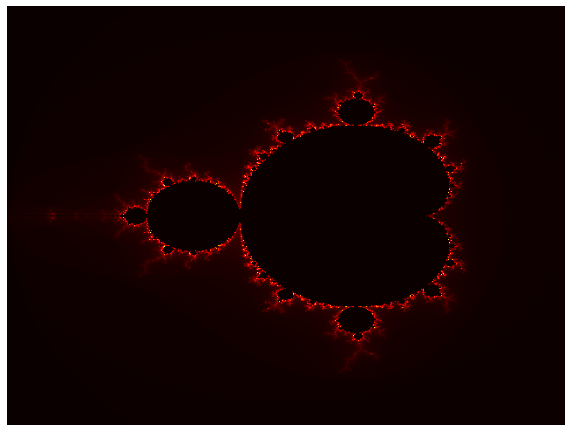

In [13]:
image = cython_mandelbrot(640, 480, -2, 1, -1.5, 1.5, 255)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(image, cmap='hot')

In [14]:
%timeit cython_mandelbrot(640, 480, -1, 2, -1.5, 1.5, 255)

1.55 s ± 50.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Это уже быстрее, чем использование чистого Python, но все же очень медленно. Да еще и медленнее Numpy-версии.

Давайте теперь скомилируем Cython с флагом `-a` или `--annotate`, который покажет нам насколько у нас активно происходит взаимодействие Python и C.

In [15]:
%%cython -a

import numpy as np

def cython_mandelbrot(
    w, h, min_x, max_x, min_y, max_y, max_iterations
):
    # Create empty image with shape = (w, h)
    image= np.zeros((h, w), dtype=np.float32)
    # Compute steps around X and Y axis
    dx = (max_x - min_x) / w
    dy = (max_y - min_y) / h
    
    # Iterate over X axis
    for x in range(w):
        real = min_x + x * dx
        # Iterate over Y axis
        for y in range(h):
            # Compute point C and Z_0
            im = min_y + y * dy
            c = real + 1j * im,
            z = 0
            # Compute the color of the point
            for k in range(max_iterations):
                z = z ** 2 + c
                if abs(z) > 2:
                    image[y, x] = k / max_iterations    
                    break
    return image

Как мы видим, здесь очень интенсивно происходят конвертации из типов Python и C. Надо менять код.

В примере ниже мы использовали почти все приколы:
- Устранили всякие проверки индексов массива
- Используем `cdivision`
- Добавили всяких штук типа `cdef float[:,:] view = image` и  `cdef complex` 

In [16]:
%%cython -a

import numpy as np
import cython

@cython.cdivision(True)
def cython_mandelbrot(
    int w, int h, float min_x, float max_x, 
    float min_y, float max_y, int max_iterations
):
    # Create empty image with shape = (w, h)
    image = np.zeros((h, w), dtype=np.float32)
    # Define c-typed variables
    cdef float[:,:] view = image
    
    cdef complex z, c, I = 1j  
    cdef int x, y, k
    cdef float dx, dy, real, im
    
    dx = <float>(max_x - min_x) / w
    dy = <float>(max_y - min_y) / h

    for x in range(w):
        real = min_x + x * dx
        for y in range(h):
            im = min_y + y * dy
            c = real + I * im
            z = 0
            for k in range(max_iterations):
                z = z ** 2 + c
                if abs(z) > 2:
                    view[y, x] = <float>(k) / max_iterations
                    break
    return image

In [17]:
%timeit cython_mandelbrot(640, 480, -1, 2, -1.5, 1.5, 255)

124 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Добавим распараллеливание при помощи OpenMP (используем `prange` вместо `range`)


In [18]:
%%cython -a
#distutils: extra_compile_args=-fopenmp
#distutils: extra_link_args=-fopenmp

import cython
import numpy as np
from cython.parallel import prange

@cython.boundscheck(False)
@cython.cdivision(True)
def cython_mandelbrot(
    int w, int h, float min_x, float max_x, 
    float min_y, float max_y, int max_iterations
):
    image = np.zeros((h, w), dtype=np.float32)
    cdef float[:,:] view = image
    
    cdef complex z, c, I = 1j  
    cdef int x, y, k
    cdef float dx, dy, real, im
    
    dx = (max_x - min_x) / w
    dy = (max_y - min_y) / h

    for x in prange(w, nogil=True):
        real = min_x + x * dx
        for y in range(h):
            im = min_y + y * dy
            c = real + I * im
            z = 0
            for k in range(max_iterations):
                z = z ** 2 + c
                if abs(z) > 2:
                    view[y, x] = <float>(k) / max_iterations
                    break
    return image

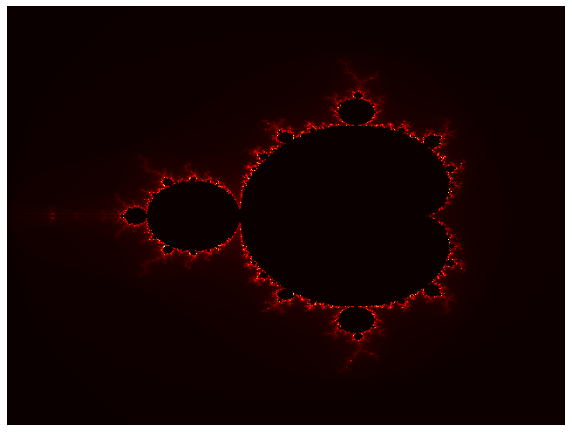

In [19]:
image = cython_mandelbrot(640, 480, -2, 1, -1.5, 1.5, 255)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(image, cmap='hot')

In [20]:
%timeit cython_mandelbrot(640, 480, -1, 2, -1.5, 1.5, 255)

47.3 ms ± 3.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Хм, результаты превосходят Numpy многократно! Но все же наш код стал ближе к C++, чем к Python. Можем ли мы также ускорить код, но без вот этих всех штук?

## Numba

Возьмем опять наш исходный код и добавим всего лишь один декоратор с разными параметрами.

In [21]:
@jit(nopython=True)
def numba_mandelbrot(
    w, h, min_x, max_x, min_y, max_y, max_iterations
):
    # Create empty image with shape = (w, h)
    image= np.zeros((h, w), dtype=np.float32)
    # Compute steps around X and Y axis
    dx = (max_x - min_x) / w
    dy = (max_y - min_y) / h
    
    # Iterate over X axis
    for x in range(w):
        real = min_x + x * dx
        # Iterate over Y axis
        for y in range(h):
            # Compute point C and Z_0
            im = min_y + y * dy
            c = real + 1j * im
            z = 0
            # Compute the color of the point
            for k in range(max_iterations):
                z = z ** 2 + c
                if abs(z) > 2:
                    image[y, x] = k / max_iterations    
                    break
    return image

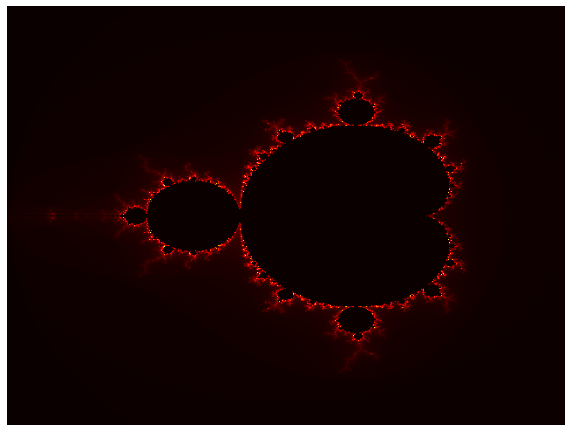

In [22]:
image = numba_mandelbrot(640, 480, -2, 1, -1.5, 1.5, 255)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(image, cmap='hot')

In [23]:
%timeit numba_mandelbrot(640, 480, -1, 2, -1.5, 1.5, 255)

126 ms ± 812 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Здорово! Мы получили такой же результат, как и при помощи Cython, но при этом добавили лишь один декоратор!

In [25]:
@jit(nopython=True, fastmath=True)
def numba_mandelbrot(
    w, h, min_x, max_x, min_y, max_y, max_iterations
):
    # Create empty image with shape = (w, h)
    image= np.zeros((h, w), dtype=np.float32)
    # Compute steps around X and Y axis
    dx = (max_x - min_x) / w
    dy = (max_y - min_y) / h
    
    # Iterate over X axis
    for x in range(w):
        real = min_x + x * dx
        # Iterate over Y axis
        for y in range(h):
            # Compute point C and Z_0
            im = min_y + y * dy
            c = real + 1j * im
            z = 0
            # Compute the color of the point
            for k in range(max_iterations):
                z = z ** 2 + c
                if abs(z) > 2:
                    image[y, x] = k / max_iterations    
                    break
    return image

In [26]:
%timeit numba_mandelbrot(640, 480, -1, 2, -1.5, 1.5, 255)

118 ms ± 4.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Добавим параллелизма:

In [27]:
from numba import prange

@jit(nopython=True, fastmath=True, parallel=True)
def numba_mandelbrot(
    w, h, min_x, max_x, min_y, max_y, max_iterations
):
    # Create empty image with shape = (w, h)
    image= np.zeros((h, w), dtype=np.float32)
    # Compute steps around X and Y axis
    dx = (max_x - min_x) / w
    dy = (max_y - min_y) / h
    
    # Iterate over X axis
    for x in prange(w):
        real = min_x + x * dx
        # Iterate over Y axis
        for y in range(h):
            # Compute point C and Z_0
            im = min_y + y * dy
            c = real + 1j * im
            z = 0
            # Compute the color of the point
            for k in range(max_iterations):
                z = z ** 2 + c
                if abs(z) > 2:
                    image[y, x] = k / max_iterations    
                    break
    return image

In [28]:
%timeit numba_mandelbrot(640, 480, -1, 2, -1.5, 1.5, 255)

47 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Taichi

Taichi это относительно диковинная библиотека, на которую я наткнулся случайно. Однако, она обладает очень впечатляющими возможностями.

In [29]:
ti.init(arch=ti.cpu)

@ti.func
def complex_sqr(z):
    return ti.Vector([z[0]**2 - z[1]**2, z[1] * z[0] * 2])


@ti.kernel
def mandelbrot_kernel(
    min_x: ti.float32, max_x: ti.float32, 
    min_y: ti.float32, max_y: ti.float32,
    max_iterations: ti.int32,
    image: ti.ext_arr()
):
    h, w = image.shape[:2]
    dx = (max_x - min_x) / w
    dy = (max_y - min_y) / h
    
    for y, x in image:
        c = ti.Vector([min_x + x * dx, min_y + y * dy])
        z = ti.Vector([0.0, 0.0])
        for i in range(max_iterations):
            z = complex_sqr(z) + c
            if z.norm() > 2:
                image[y, x] = i / max_iterations
                break

            

def taichi_mandelbrot(w, h, min_x, max_x, min_y, max_y, max_iterations):
    image= np.zeros((h, w), dtype=np.float64)
    mandelbrot_kernel(min_x, max_x, min_y, max_y, max_iterations, image)
    return image
    


[Taichi] Starting on arch=x64


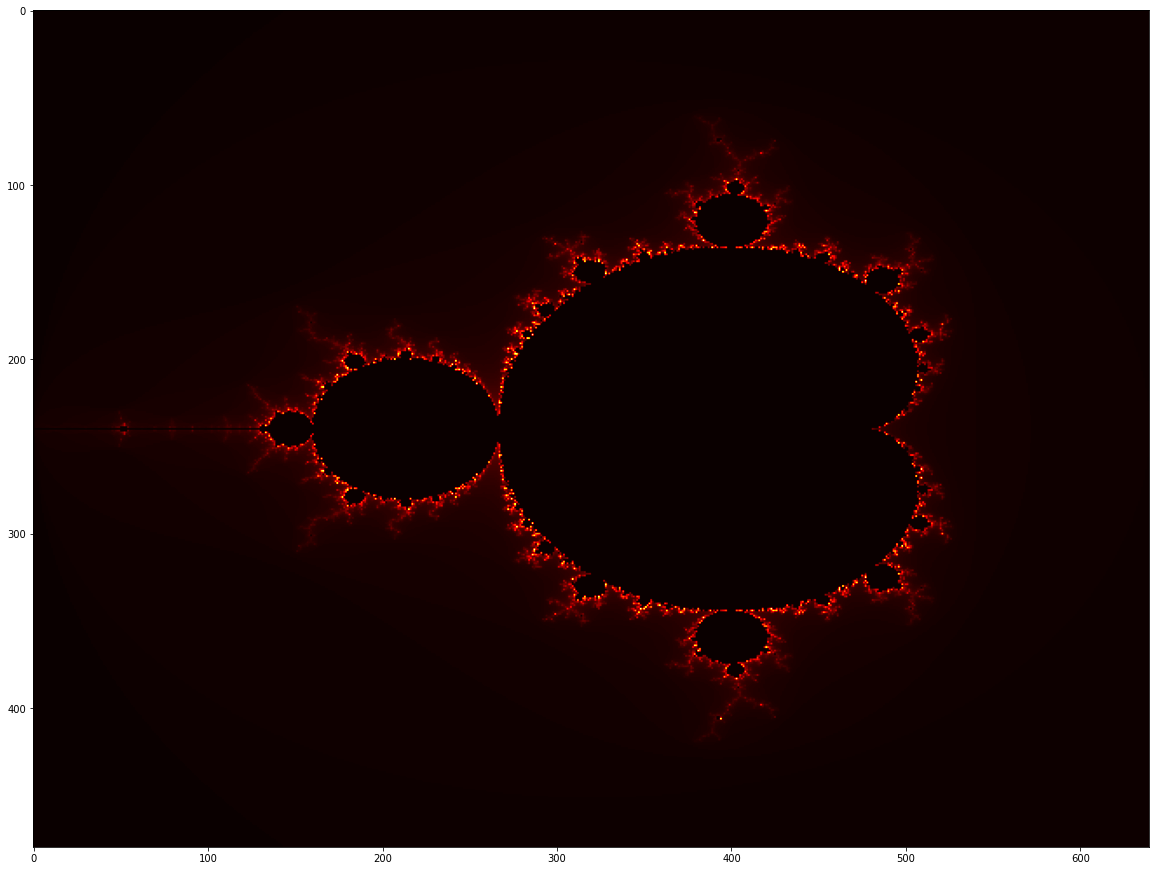

In [30]:
image_np = taichi_mandelbrot(640, 480, -2, 1, -1.5, 1.5, 255)
plt.figure(figsize=(20, 20))
plt.imshow(image_np, cmap='hot')

In [31]:
%timeit taichi_mandelbrot(640, 480, -2, 1, -1.5, 1.5, 255)

13.7 ms ± 461 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
ti.reset()

In [33]:
ti.init(arch=ti.gpu)

@ti.func
def complex_sqr(z):
    return ti.Vector([z[0]**2 - z[1]**2, z[1] * z[0] * 2])


@ti.kernel
def mandelbrot_kernel(
    min_x: ti.float32, max_x: ti.float32, 
    min_y: ti.float32, max_y: ti.float32,
    max_iterations: ti.int32,
    image: ti.ext_arr()
):
    h, w = image.shape[:2]
    dx = (max_x - min_x) / w
    dy = (max_y - min_y) / h
    
    for y, x in image:
        c = ti.Vector([min_x + x * dx, min_y + y * dy])
        z = ti.Vector([0.0, 0.0])
        for i in range(max_iterations):
            z = complex_sqr(z) + c
            if z.norm() > 2:
                image[y, x] = i / max_iterations
                break

            

def taichi_mandelbrot(w, h, min_x, max_x, min_y, max_y, max_iterations):
    image= np.zeros((h, w), dtype=np.float64)
    mandelbrot_kernel(min_x, max_x, min_y, max_y, max_iterations, image)
    return image
    

[Taichi] Starting on arch=cuda


In [34]:
%timeit taichi_mandelbrot(640, 480, -2, 1, -1.5, 1.5, 255)

1.15 ms ± 91.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [35]:
ti.reset()